Processing Ring dataset...
SVM Accuracy on Ring: 0.9791
SVM Classification Error on Ring: 2.09%
SVM Confusion Matrix on Ring:
[[5308   25]
 [ 184 4483]]


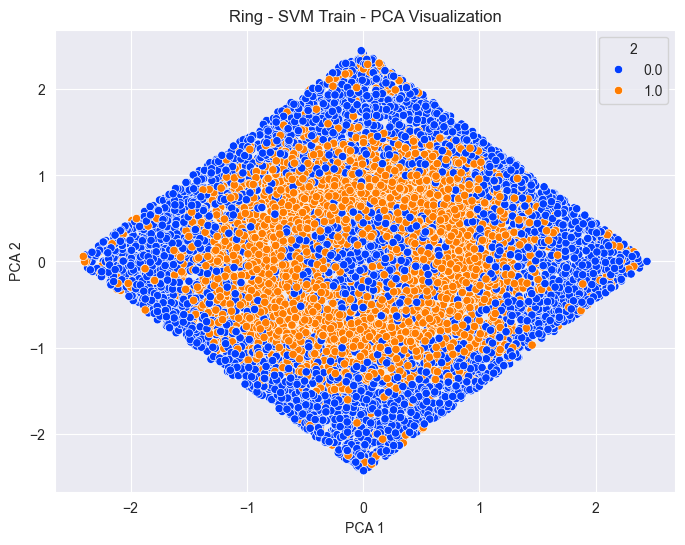

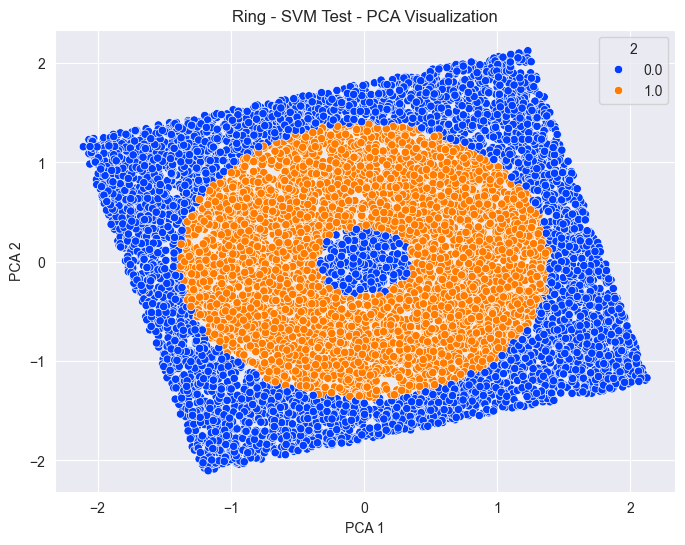

MLP Accuracy on Ring: 0.9601
MLP Classification Error on Ring: 3.99%
MLP Confusion Matrix on Ring:
[[5292   41]
 [ 358 4309]]


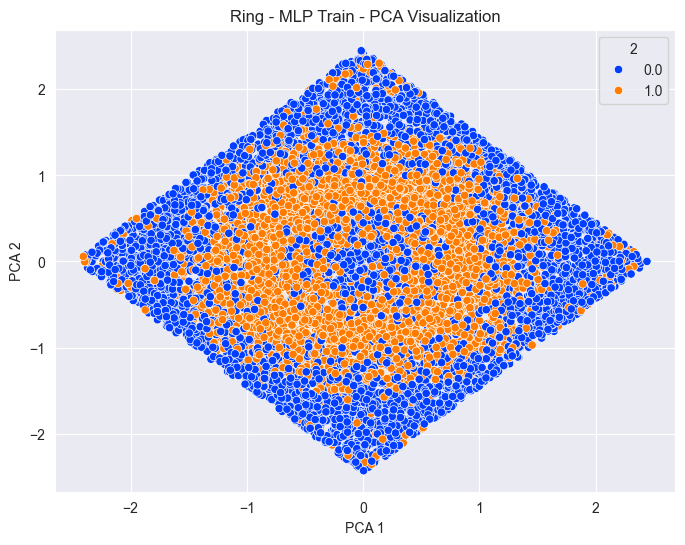

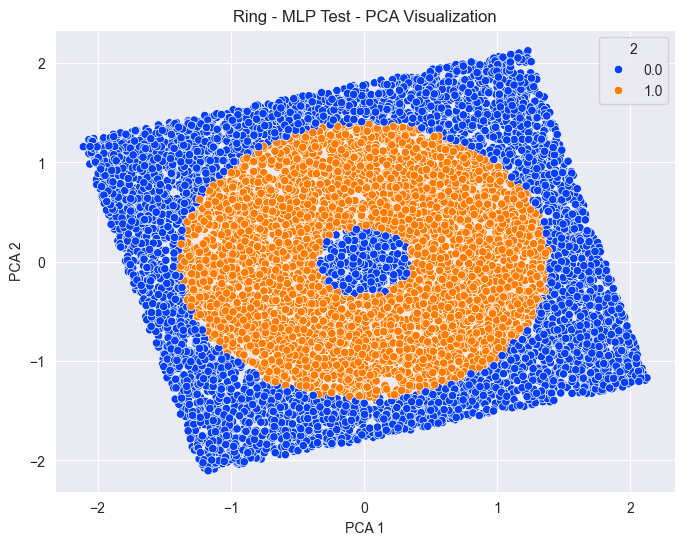

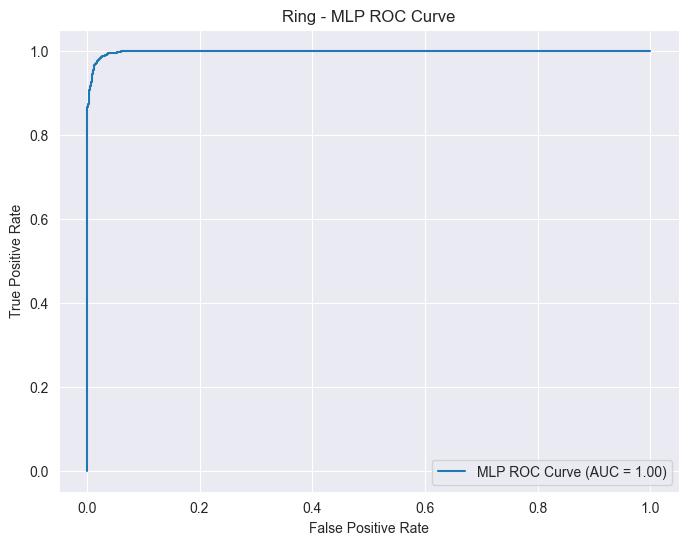

Logistic Regression Accuracy on Ring: 0.9086
Logistic Regression Classification Error on Ring: 9.14%
Logistic Regression Confusion Matrix on Ring:
[[5033  300]
 [ 614 4053]]


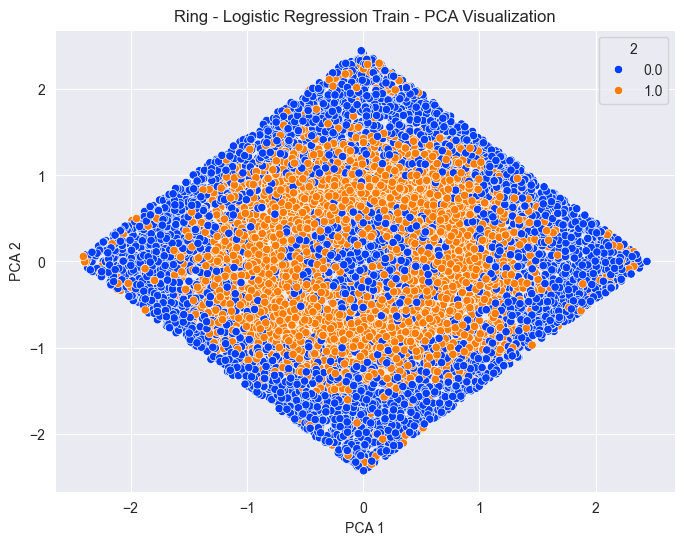

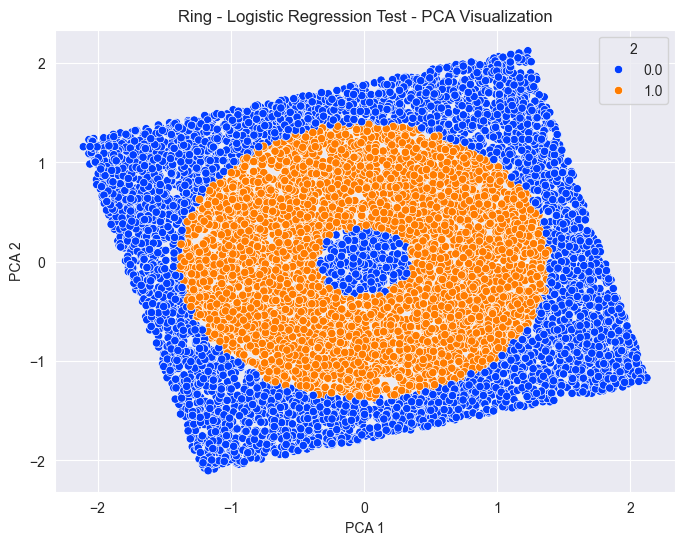

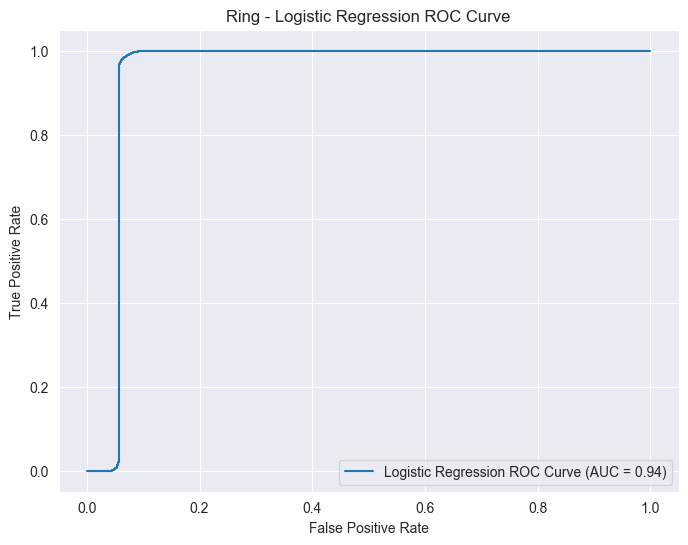

Processing Bank dataset...
SVM Accuracy on Bank: 0.6939791211459092
SVM Classification Error on Bank: 30.60208788540908%
SVM Confusion Matrix on Bank:
[[5584  114]
 [2407  133]]


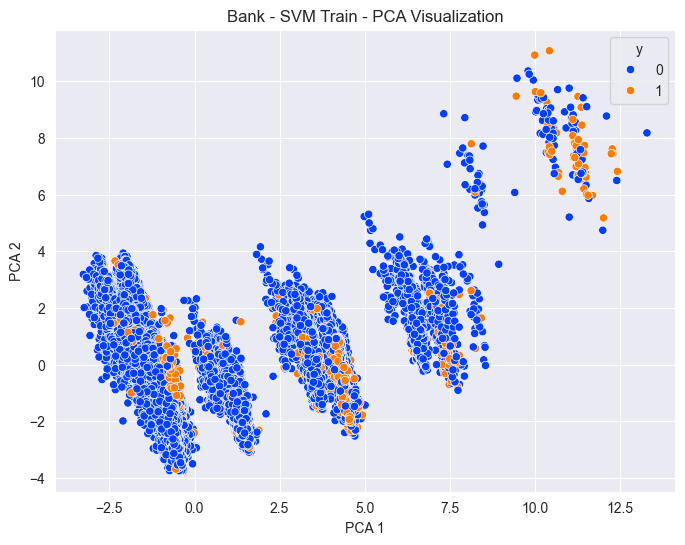

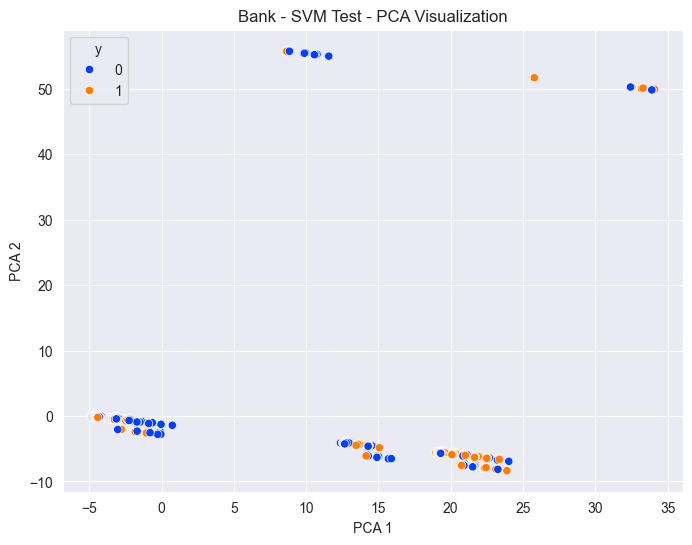

MLP Accuracy on Bank: 0.682689973294489
MLP Classification Error on Bank: 31.731002670551106%
MLP Confusion Matrix on Bank:
[[5199  499]
 [2115  425]]


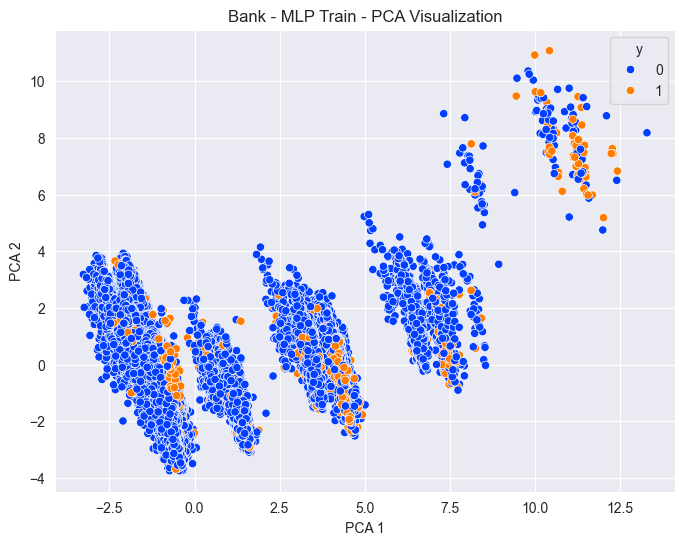

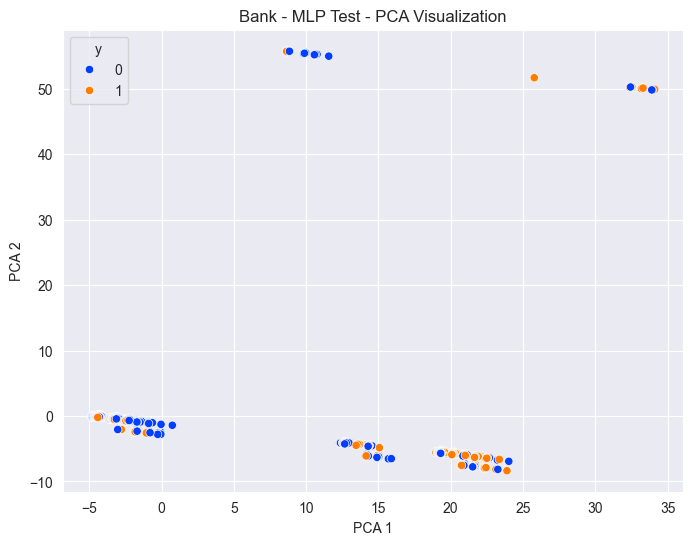

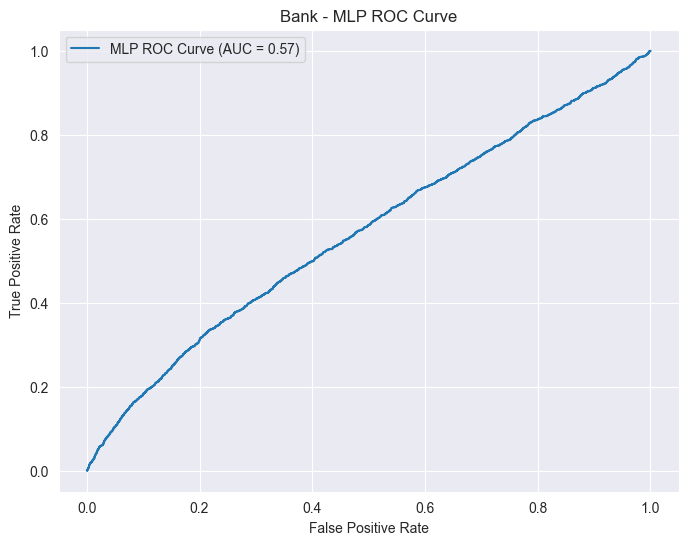

/Users/mwr/.conda/envs/A2_RACCA/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on Bank: 0.6624180626365622
Logistic Regression Classification Error on Bank: 33.75819373634377%
Logistic Regression Confusion Matrix on Bank:
[[4895  803]
 [1978  562]]


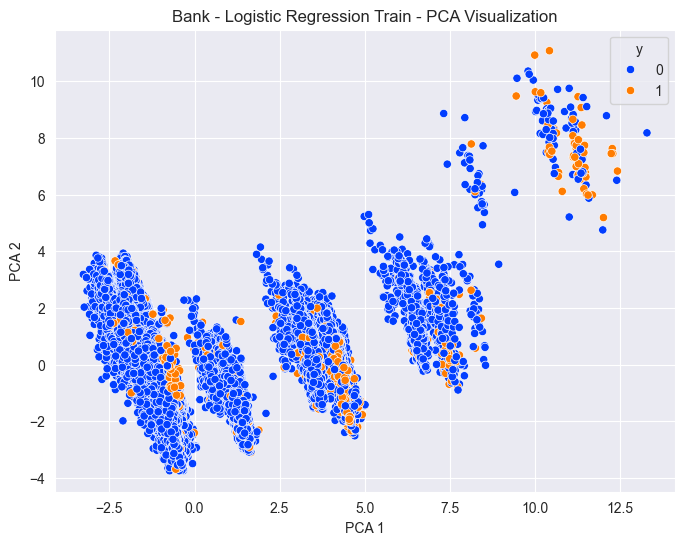

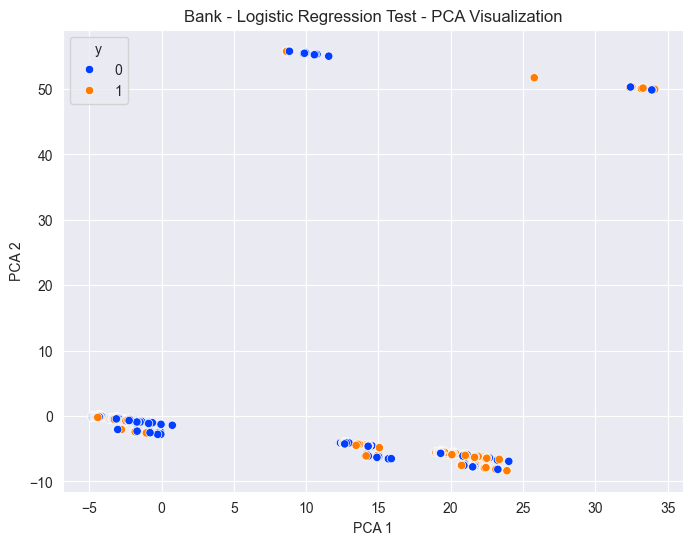

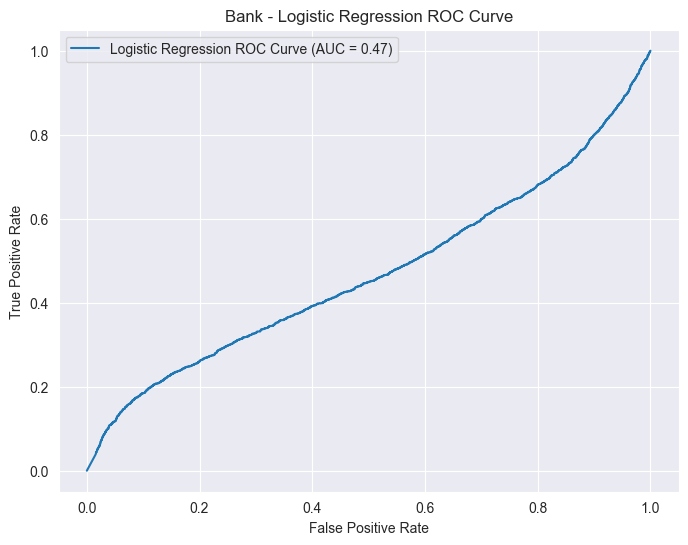

Processing Diabetes dataset...
SVM Accuracy on Diabetes: 0.7792207792207793
SVM Classification Error on Diabetes: 22.07792207792208%
SVM Confusion Matrix on Diabetes:
[[84 12]
 [22 36]]


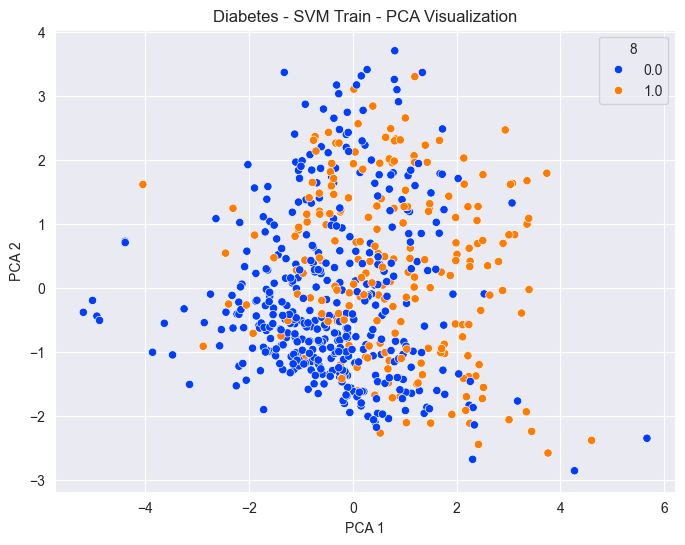

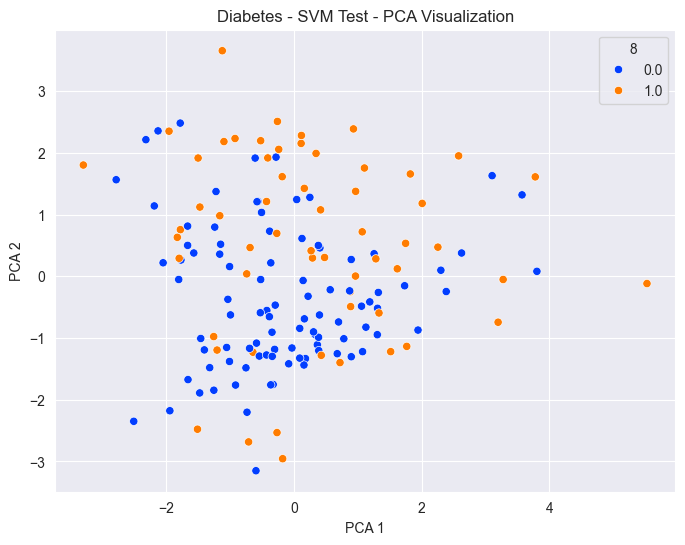

MLP Accuracy on Diabetes: 0.7467532467532467
MLP Classification Error on Diabetes: 25.324675324675326%
MLP Confusion Matrix on Diabetes:
[[77 19]
 [20 38]]


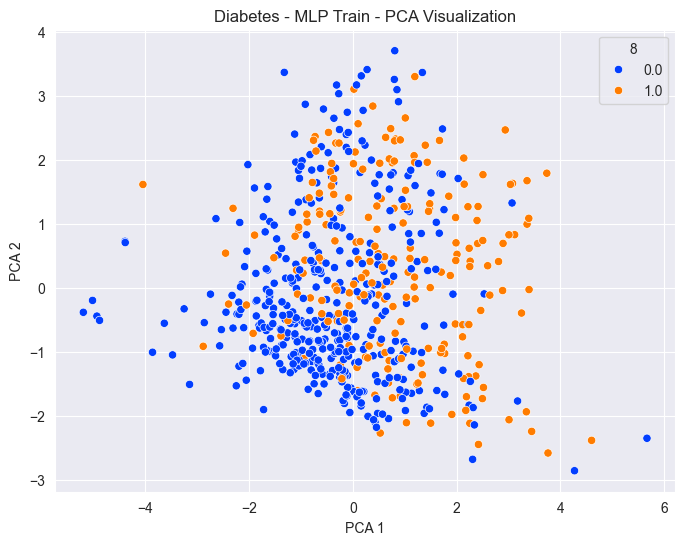

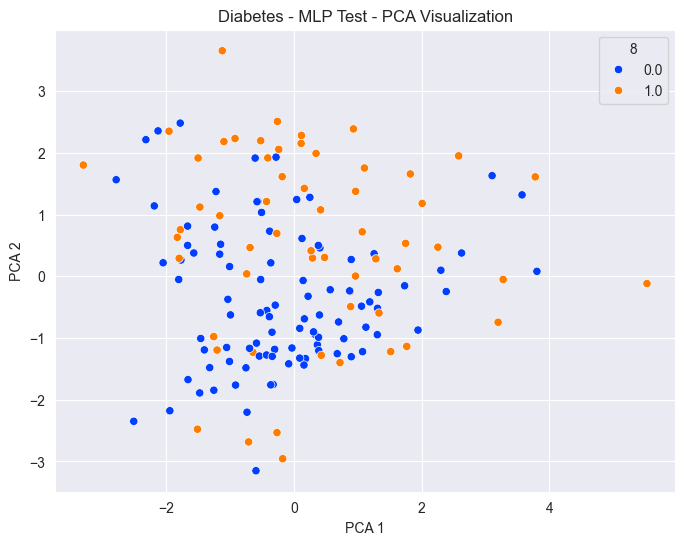

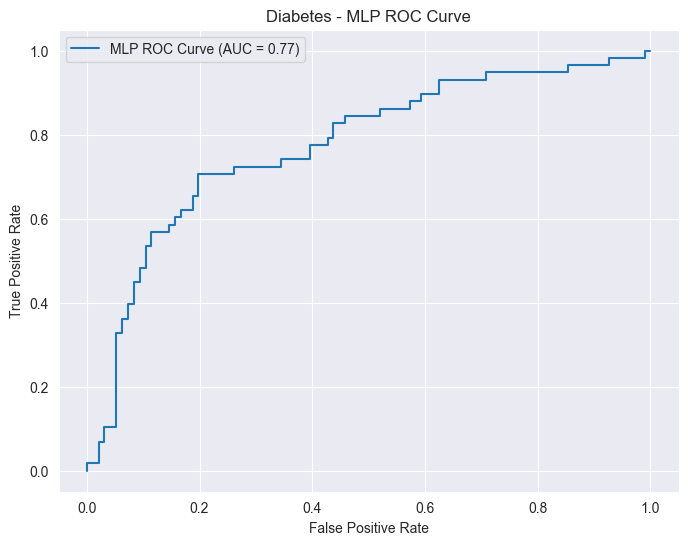

Logistic Regression Accuracy on Diabetes: 0.6883116883116883
Logistic Regression Classification Error on Diabetes: 31.16883116883117%
Logistic Regression Confusion Matrix on Diabetes:
[[74 22]
 [26 32]]


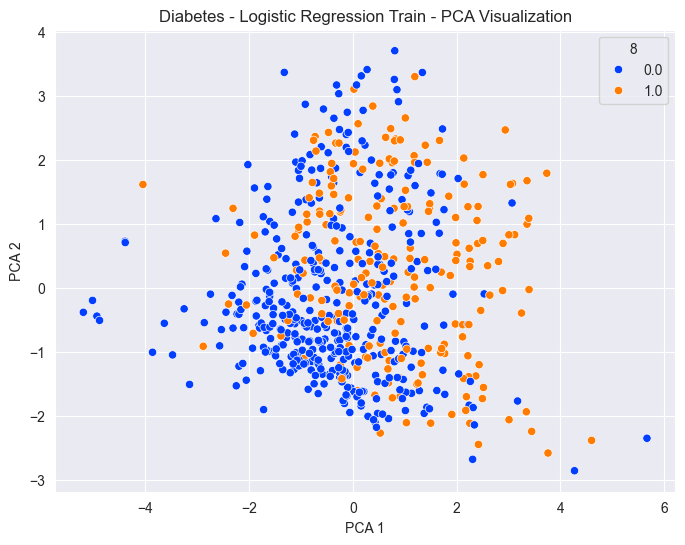

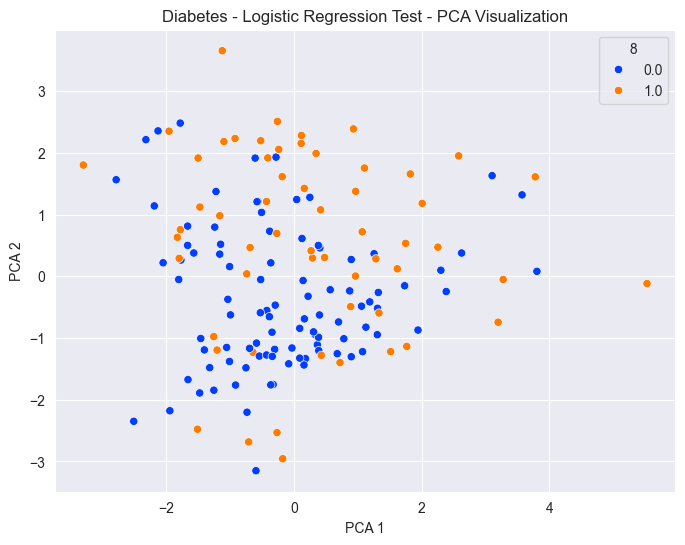

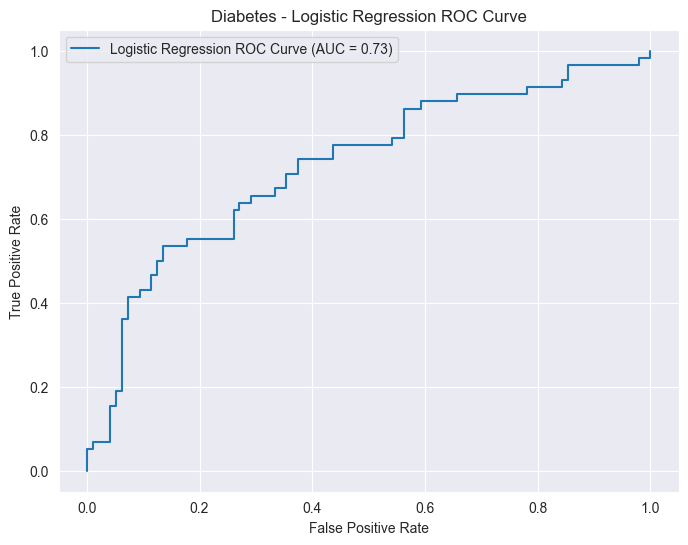

In [20]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Function to split features and targets
def split_features_target(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    y = y.replace(np.nan, 0)  # Handle NaN values in target
    if y.dtype == 'object':
        y = y.map({'yes': 1, 'no': 0})  # Convert target to numeric if it's not
    return X, y

# Function for dimensionality reduction and visualization
def visualize_data(X, y, title):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette='bright')
    plt.title(f'{title} - PCA Visualization')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

# Define a function for classification error calculation
def classification_error(y_true, y_pred):
    n_01 = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    n_10 = np.sum(np.logical_and(y_true == 1, y_pred == 0))
    n_00 = np.sum(np.logical_and(y_true == 0, y_pred == 0))
    n_11 = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    
    return 100 * (n_01 + n_10) / (n_00 + n_11 + n_01 + n_10)

# Initialize models with appropriate configurations
svm_model = SVC(kernel='rbf', probability=True, C=10.0, gamma='scale')
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=5000, alpha=0.01, learning_rate='adaptive', random_state=42)
log_reg_model = make_pipeline(PolynomialFeatures(degree=3), LogisticRegression(max_iter=5000, C=1.0))

# Create a dictionary for models
models = {
    'SVM': svm_model,
    'MLP': mlp_model,
    'Logistic Regression': log_reg_model
}

# Train, evaluate, and visualize for each dataset and each model
for dataset_name, (X_train, y_train, X_test, y_test) in datasets.items():
    print(f"Processing {dataset_name} dataset...")
    
    # Handle NaN values by dropping rows with missing values
    X_train = X_train.dropna()
    y_train = y_train[y_train.index.isin(X_train.index)]
    
    X_test = X_test.dropna()
    y_test = y_test[y_test.index.isin(X_test.index)]
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)
        
        # Calculate accuracy and classification error
        accuracy = accuracy_score(y_test, y_pred)
        error = classification_error(y_test, y_pred)
        
        print(f"{model_name} Accuracy on {dataset_name}: {accuracy}")
        print(f"{model_name} Classification Error on {dataset_name}: {error}%")
        
        # Calculate and print confusion matrix
        confusion = confusion_matrix(y_test, y_pred)
        print(f"{model_name} Confusion Matrix on {dataset_name}:\n{confusion}\n")
        
        # Visualize the data
        visualize_data(X_train_scaled, y_train, f"{dataset_name} - {model_name} Train")
        visualize_data(X_test_scaled, y_test, f"{dataset_name} - {model_name} Test")
        
        # For BP and MLR, calculate ROC curve and AUC
        if model_name in ('MLP', 'Logistic Regression'):
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of positive class
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            auc = roc_auc_score(y_test, y_pred_proba)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f"{model_name} ROC Curve (AUC = {auc:.2f})")
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{dataset_name} - {model_name} ROC Curve')
            plt.legend()
            plt.show()
